In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as po
import plotly.graph_objs as go
from plotly import tools
import load
import descriptions

po.init_notebook_mode(connected=True)

# Contents


1. The datasets
2. av_tumour
3. av_patient <br/>
&nbsp; 3.1  merge av_tumour and av_patient
4. sact_regimen
5. sact_tumour <br/>
&nbsp; 5.1  merge sact_tumour sact_regimen
6. sact_outcome <br/>
&nbsp; 6.1 merge sact_outcome and sact_regimen
7. sact_cycle
8. sact_patient
9. sact_drug_detail
10. Patient pathway/single view of patient <br/>
&nbsp; 10.1 merging all datasets <br/>
&nbsp; 10.2 patient pathways <br/>

# 1. The datasets

This is a table of all the columns in each dataset, there are a lot so it might be useful to see all of them in one table

**can scroll this table left/right**

In [2]:
datadict = pd.ExcelFile('Simulacrum-data-dictionary.xlsx')
sheets = datadict.sheet_names[1:]
DF = pd.DataFrame()
for sheet in sheets:
    df = pd.read_excel(datadict,sheet)
    df[sheet] = df['Field name']
    DF = pd.concat([DF,df[sheet]], axis=1)
    DF = DF.replace(np.nan, '', regex=True)
DF

,AV_PATIENT,AV_TUMOUR,SACT PATIENT,SACT TUMOUR,SACT REGIMEN,SACT OUTCOME,SACT CYCLE,SACT DRUG_DETAIL
0,PATIENTID,TUMOURID,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_OUTCOME_ID,MERGED_CYCLE_ID,MERGED_DRUG_DETAIL_ID
1,SEX,PATIENTID,LINK_NUMBER,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID,MERGED_REGIMEN_ID,MERGED_CYCLE_ID
2,LINKNUMBER,DIAGNOSISDATEBEST,,CONSULTANT_SPECIALITY_CODE,HEIGHT_AT_START_OF_REGIMEN,DATE_OF_FINAL_TREATMENT,CYCLE_NUMBER,ORG_CODE_OF_DRUG_PROVIDER
3,ETHNICITY,SITE_ICD10_O2,,PRIMARY_DIAGNOSIS,WEIGHT_AT_START_OF_REGIMEN,REGIMEN_MOD_DOSE_REDUCTION,START_DATE_OF_CYCLE,ACTUAL_DOSE_PER_ADMINISTRATION
4,DEATHCAUSECODE_1A,SITE_ICD10_O2_3CHAR,,MORPHOLOGY_CLEAN,INTENT_OF_TREATMENT,REGIMEN_MOD_TIME_DELAY,OPCS_PROCUREMENT_CODE,OPCS_DELIVERY_CODE
5,DEATHCAUSECODE_1B,MORPH_ICD10_O2,,,DATE_DECISION_TO_TREAT,REGIMEN_MOD_STOPPED_EARLY,PERF_STATUS_START_OF_CYCLE,ADMINISTRATION_ROUTE
6,DEATHCAUSECODE_1C,BEHAVIOUR_ICD10_O2,,,START_DATE_OF_REGIMEN,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,ADMINISTRATION_DATE
7,DEATHCAUSECODE_2,T_BEST,,,MAPPED_REGIMEN,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,DRUG_GROUP
8,DEATHCAUSECODE_UNDERLYING,N_BEST,,,CLINICAL_TRIAL,MERGED_TUMOUR_ID,,MERGED_PATIENT_ID
9,DEATHLOCATIONCODE,M_BEST,,,CHEMO_RADIATION,,,MERGED_TUMOUR_ID


Diagram of how the datasets are linked:

<img src="docs/tablestructure.jpeg" alt="ts" width="500"/>

The data can be downloaded from https://simulacrum.healthdatainsight.org.uk/requesting-data/

# 2. Tumour

In [3]:
av_tumour = load.load_table('av_tumour', add_descriptions=True) #add_descriptions=True adds columns of
                                                                #descriptions to the codes
display(av_tumour.head())
print(av_tumour.shape)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,HISTOLOGY_DESC
0,10000001,10000001,2015-11-06,C443,C44,8090,3,NaN,NaN,NaN,...,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEFT,BASAL CELL CARCINOMA NOS
1,10000002,10000002,2015-10-06,C449,C44,8090,3,NaN,NaN,NaN,...,North West Cancer Intelligence Service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
2,10000003,10000003,2013-01-30,C449,C44,8090,3,NaN,NaN,NaN,...,Northern & Yorkshire Cancer Registry & Informa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
3,10000004,10000004,2015-09-15,C449,C44,8090,3,NaN,NaN,NaN,...,Thames Cancer Registry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS
4,10000005,10000005,2014-11-01,C449,C44,8090,3,NaN,NaN,NaN,...,Northern & Yorkshire Cancer Registry & Informa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,BASAL CELL CARCINOMA NOS


(1402817, 51)


Unique diagnosis years:

In [4]:
av_tumour["DIAGNOSISDATEBEST"].apply(lambda x: x.year).unique()

array([2015, 2013, 2014])

top 20 diagnosed tumours:

In [5]:
av_tumour['SITE_ICD10_O2_3CHAR_DESC'].value_counts()[:20]

Other malignant neoplasms of skin                       350130
Malignant neoplasm of breast                            133907
Malignant neoplasm of prostate                          119347
Malignant neoplasm of bronchus and lung                 102350
Carcinoma in situ of cervix uteri                        76678
Malignant neoplasm of colon                              65825
Malignant melanoma of skin                               38155
Malignant neoplasm of rectum                             27163
Malignant neoplasm of kidney, except renal pelvis        26195
Carcinoma in situ of other and unspecified sites         25193
Malignant neoplasm of bladder                            24643
Malignant neoplasm of corpus uteri                       21849
Malignant neoplasm of pancreas                           21344
Malignant neoplasm of oesophagus                         20996
Carcinoma in situ of breast                              19777
Diffuse non-Hodgkin's lymphoma                         

Can compare this with:

https://www.cancerresearchuk.org/health-professional/cancer-statistics/incidence/common-cancers-compared#heading-Zero

We have the top diagnosed cancer as skin cancer, this may be due to single patients having multiple melanomas of skin. 

Making some stacked bar plots of the tumour features:

In [6]:
def Stackedbarplot(df,col1,col2,tickmode='auto'):
    """
    Creates a stacked bar plot with col1 as the stacked bars
    and col2 on the x-axis
    
    df: dataframe containing col1 and col2 as columns
    col1: name of column as string
    col2: name of column as string
    tickmode: when == 'linear', show all x-axis labels
    """
    
    #Get dataframe of col1,col2 and frequency of people with that col1/col2
    df = df[[col1,col2]] \
                .groupby([col2, col1]) \
                .agg({col1:'size'}) \
                .rename(columns={col1:'count'}) \
                .reset_index()
    
    #pivot the table in the correct format for a stacked bar plot
    df = df.pivot(index=col2, columns=col1)['count']
    x = df.index
    
    #create plotly plot
    data = []

    np.random.seed(seed=7)

    for stack in df.keys():
        color=np.random.randint(255, size=(1, 3))[0]
        
        trace = go.Bar(
                x=[str(i) for i in x],
                y=df[stack],
                name=stack,marker = dict(color='rgb({}, {}, {})'.format(*color)))

        data.append(trace)

    layout = go.Layout(barmode='stack',hovermode='closest',
                       xaxis=dict(title=col2,tickmode=tickmode), 
                       yaxis=dict(title="count"))

    fig = go.Figure(data=data, layout=layout)

    po.iplot(fig)
    

In [7]:
Stackedbarplot(av_tumour, 'SITE_ICD10_O2_3CHAR', 'AGE')

The colours on this graph correspond to tumour site

We can compare this graph with a graph from cancerresearchuk:

https://www.cancerresearchuk.org/health-professional/cancer-statistics/incidence/age#heading-Zero

The distribution is similar except the peak at around 25 years due to D06, you can convert D06 into actual words:

In [8]:
descriptions.get_descriptions('D06', 'icd')[0]

'CARCINOMA-IN-SITU OF CERVIX UTERI'

The peak due to cervical cancer is also apparent in this graph from cancerresearchuk:

https://www.cancerresearchuk.org/health-professional/cancer-statistics/statistics-by-cancer-type/cervical-cancer/incidence#heading-One

<br/>
<br/>

Can also plot other columns of av_tumour, for example behaviour:

In [9]:
Stackedbarplot(av_tumour, 'SITE_ICD10_O2_3CHAR', 'BEHAVIOUR_ICD10_O2')

The meaning of behaviour:

In [10]:
for i in range(10):
    print(i,descriptions.get_descriptions(str(i),'behaviour')[0])

0 BENIGN
1 UNCERTAIN
2 IN SITU
3 MALIGNANT
4 nan
5 MICRO-INVASIVE
6 MALIGNANT, METASTATIC/ SECONDARY SITE
7 nan
8 nan
9 MALIGNANT, UNCERTAIN WHETHER PRIMARY OR METASTATIC


**Errors of av_tumour**

incorrect 3 letter ICD10 codes compared to the full code: e.g. C160 should correspond to C16

In [11]:
incorrect = av_tumour['SITE_ICD10_O2'].apply(lambda s: str(s)[0:3]) \
            != av_tumour['SITE_ICD10_O2_3CHAR']
print(incorrect.value_counts())
display(av_tumour[incorrect].tail())


False    1348656
True       54161
dtype: int64


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,...,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,HISTOLOGY_DESC
1402811,220052217,220023092,2014-09-30,C160,C44,8312,3,NaN,NaN,NaN,...,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOT APPLICABLE,CARCINOMA RENAL CELL
1402812,220052218,220023285,2015-09-03,C313,C34,8140,3,1a,0,0,...,Welsh Cancer Intelligence & Surveillance Unit,NaN,NaN,NaN,Curative,NaN,Yes - Clinical Nurse Specialist present when P...,NaN,RIGHT,ADENOCARCINOMA NOS
1402814,220052225,220045122,2015-01-30,D075,D01,8140,2,NaN,NaN,NaN,...,Oxford Cancer Intelligence Unit,NaN,NaN,NaN,Curative,Able to carry out all normal activity without ...,NaN,NaN,NOT APPLICABLE,ADENOCARCINOMA IN SITU
1402815,220052228,220010521,2015-11-02,C051,C61,8000,3,NaN,2,1,...,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,Non Curative,"Able to walk and capable of all self care, but...",NaN,NaN,NOT APPLICABLE,NEOPLASM MALIGNANT
1402816,220052229,220014422,2015-10-27,C441,C64,8046,3,2a,2,1,...,Eastern Cancer Registration & Information Centre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEFT,NON SMALL CELL CARCINOMA OF LUNG


# 3. Patient

In [12]:
av_patient = load.load_table('av_patient', add_descriptions=True)
display(av_patient.head())

,PATIENTID,SEX,LINKNUMBER,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,...,VITALSTATUSDATE,SEX_DESC,ETHNICITY_DESC,DEATHLOCATIONCODE_DESC,DEATHCAUSECODE_1A_DESC,DEATHCAUSECODE_1B_DESC,DEATHCAUSECODE_1C_DESC,DEATHCAUSECODE_2_DESC,DEATHCAUSECODE_UNDERLYING_DESC,NEWVITALSTATUS_DESC
0,10000001,2,810000001,A,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-01-17,FEMALE,WHITE BRITISH,NaN,,,,,,Alive
1,10000002,2,810000002,Z,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-01-14,FEMALE,NOT STATED,NaN,,,,,,Alive
2,10000003,1,810000003,A,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-01-17,MALE,WHITE BRITISH,NaN,,,,,,Alive
3,10000004,1,810000004,A,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-01-13,MALE,WHITE BRITISH,NaN,,,,,,Alive
4,10000005,2,810000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2017-01-16,FEMALE,NaN,NaN,,,,,,Alive


In [13]:
av_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322100 entries, 0 to 1322099
Data columns (total 21 columns):
PATIENTID                         1322100 non-null int64
SEX                               1322100 non-null category
LINKNUMBER                        1322100 non-null int64
ETHNICITY                         1192249 non-null category
DEATHCAUSECODE_1A                 330280 non-null object
DEATHCAUSECODE_1B                 98085 non-null object
DEATHCAUSECODE_1C                 18106 non-null object
DEATHCAUSECODE_2                  141982 non-null object
DEATHCAUSECODE_UNDERLYING         327910 non-null object
DEATHLOCATIONCODE                 330381 non-null category
NEWVITALSTATUS                    1322100 non-null category
VITALSTATUSDATE                   1322100 non-null datetime64[ns]
SEX_DESC                          1322100 non-null object
ETHNICITY_DESC                    1192249 non-null object
DEATHLOCATIONCODE_DESC            323235 non-null object
DEATHCAUSECO

Which years are the data from?

In [14]:
av_patient['VITALSTATUSDATE'].apply(lambda x: x.year).unique()

array([2017, 2016, 2015, 2013, 2014, 1900])

Which years are the data from?

In [15]:
av_patient['VITALSTATUSDATE'].apply(lambda x: x.year).unique()

array([2017, 2016, 2015, 2013, 2014, 1900])

Frequency of the top 20 death causes:

In [16]:
#group by sex and count the type of deaths
top20 = av_patient['DEATHCAUSECODE_UNDERLYING_DESC'].value_counts()[1:20].keys()
top20 = av_patient.loc[av_patient['DEATHCAUSECODE_UNDERLYING_DESC'].isin(top20)]
top20bysex = top20.groupby(['SEX','DEATHCAUSECODE_UNDERLYING_DESC']) \
                  .agg({'DEATHCAUSECODE_UNDERLYING_DESC':'size'})

male = top20bysex.loc['1']['DEATHCAUSECODE_UNDERLYING_DESC']
female = top20bysex.loc['2']['DEATHCAUSECODE_UNDERLYING_DESC']

#plotly plots
trace1 = go.Bar(
    x=female.index,
    y=female.values,
    name='female'
)
trace2 = go.Bar(
    x=male.index,
    y=male.values,
    name='male'
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

You can compare this graph with:

https://www.cancerresearchuk.org/health-professional/cancer-statistics/mortality/common-cancers-compared#heading-Zero

Which is from 2015

**Errors from av_patient**

non null `"DEATHCAUSECODE_UNDERLYING"` and `"NEWVITALSTATUS" != "D"`:

In [17]:
dead_alive = av_patient[(av_patient["DEATHCAUSECODE_UNDERLYING"].notnull()) \
                        & (av_patient["NEWVITALSTATUS"] != "D")]
len(dead_alive)

179511

### 3.2 merge av_tumour and av_patient

In [18]:
tumour_patient = pd.merge(av_tumour,av_patient,on='PATIENTID')
print(av_tumour.shape,av_patient.shape,tumour_patient.shape) 

(1402817, 51) (1322100, 21) (1402817, 71)


create column with days between date of vital status taken and date of diagnosis

In [19]:
tumour_patient['VITAL - DIAGNOSIS (days)'] = tumour_patient['VITALSTATUSDATE'] - tumour_patient['DIAGNOSISDATEBEST']
tumour_patient['VITAL - DIAGNOSIS (days)'] = [i.days for i in tumour_patient['VITAL - DIAGNOSIS (days)']]
tumour_patient = tumour_patient[tumour_patient['VITAL - DIAGNOSIS (days)'] >= 0] #some have vital status in 1900

print("stats for days being alive")
tumour_patient['VITAL - DIAGNOSIS (days)'].describe()


stats for days being alive


count    1.402784e+06
mean     7.674820e+02
std      4.079234e+02
min      0.000000e+00
25%      4.660000e+02
50%      7.690000e+02
75%      1.105000e+03
max      1.484000e+03
Name: VITAL - DIAGNOSIS (days), dtype: float64

# 4. Sact_regimen

https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python - loading sim_sact_regimen

there are multiple regimens for some tumours

In [20]:
sact_regimen = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_regimen.csv',encoding="ISO-8859-1")
print(sact_regimen.shape)
display(sact_regimen.head())

(471919, 12)


,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID,BENCHMARK_GROUP
0,10000001,10000001,-1.0,NaN,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES
1,10000002,10000002,NaN,NaN,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES
2,10000003,10000003,NaN,NaN,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES
3,10000004,10000004,NaN,NaN,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB
4,10000005,10000005,0.0,NaN,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE


# 5. Sact_tumour

tumours that have received systemic anti-cancer therapy

In [21]:
sact_tumour = load.load_table('sact_tumour')
sact_tumour.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN
0,10000001,10000235,101,C61,81403
1,10000002,10000315,101,C679,81403
2,10000003,10000337,100,C500,NaN
3,10000004,10000480,303,C829,NaN
4,10000005,10000533,823,D473,NaN


### 5.1 merge sact_tumour sact_regimen

In [22]:
tumour_regimen = pd.merge(sact_tumour,sact_regimen,on='MERGED_TUMOUR_ID')
print(sact_tumour.shape, sact_regimen.shape, tumour_regimen.shape) 

(299727, 5) (471919, 12) (471919, 16)


In [23]:
tumour_regimen.head()

,MERGED_TUMOUR_ID,MERGED_PATIENT_ID_x,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,MERGED_REGIMEN_ID,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_y,BENCHMARK_GROUP
0,10000001,10000235,101,C61,81403,10000001,-1.0,NaN,N,2015-03-08,2015-03-08,DEGARELIX,NaN,N,10000235,HORMONES
1,10000002,10000315,101,C679,81403,10000002,NaN,NaN,P,2016-07-09,2016-07-10,BICALUTAMIDE + GOSERELIN,NaN,N,10000315,HORMONES
2,10000003,10000337,100,C500,NaN,10000003,NaN,NaN,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES
3,10000004,10000480,303,C829,NaN,10000004,NaN,NaN,NaN,2015-03-17,2015-03-23,Rituximab,N,NaN,10000480,RITUXIMAB
4,10000005,10000533,823,D473,NaN,10000005,0.0,NaN,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE


In [24]:
#only include top20 benchmark group and top30 primary diagnosis in tumour_regimen
#this is beccause there are 809 different benchmarks and 700 different diagnosis

top20bench = tumour_regimen['BENCHMARK_GROUP'].value_counts()[:20].keys()
top30diag = tumour_regimen['PRIMARY_DIAGNOSIS'].value_counts()[:30].keys()

topbenchdiag = tumour_regimen.loc[(tumour_regimen['BENCHMARK_GROUP'].isin(top20bench)) & 
                                  (tumour_regimen['PRIMARY_DIAGNOSIS'].isin(top30diag))]

In [25]:
Stackedbarplot(topbenchdiag,'BENCHMARK_GROUP', 'PRIMARY_DIAGNOSIS')

This is a frequency plot of primary diagnosis of patients with the different colours as the BENCHMARK_GROUP(type of regimen i think) given to that patient.

this only shows the top 30 PRIMARY_DIAGNOSIS and top 30 BENCHMARK_GROUP

# 6. sact_outcome

In [26]:
sact_outcome = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_outcome.csv')
sact_outcome.head()

,MERGED_OUTCOME_ID,MERGED_REGIMEN_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000003,2014-01-09,N,N,N,NaN,10000337,10000003
1,10000002,10000005,NaN,Y,Y,N,NaN,10000533,10000005
2,10000003,10000006,NaN,N,Y,N,NaN,10000697,10000006
3,10000004,10000007,NaN,Y,NaN,N,NaN,10000697,10000006
4,10000005,10000008,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036


In [27]:
sact_outcome.shape

(351668, 9)

### 6.1 merge sact_outcome and sact_regimen

In [28]:
outcome_regimen = pd.merge(sact_regimen,sact_outcome,on='MERGED_REGIMEN_ID')
print(sact_outcome.shape, sact_regimen.shape, outcome_regimen.shape) 

(351668, 9) (471919, 12) (351668, 20)


In [29]:
outcome_regimen.head()

,MERGED_REGIMEN_ID,MERGED_TUMOUR_ID_x,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_x,BENCHMARK_GROUP,MERGED_OUTCOME_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID_y,MERGED_TUMOUR_ID_y
0,10000003,10000003,NaN,NaN,P,2014-01-09,2014-01-09,EXEMESTANE,02,N,10000337,HORMONES,10000001,2014-01-09,N,N,N,NaN,10000337,10000003
1,10000005,10000005,0.00,NaN,C,2012-12-30,2013-03-11,Hydroxycarbamide,N,N,10000533,HYDROXYCARBAMIDE,10000002,NaN,Y,Y,N,NaN,10000533,10000005
2,10000006,10000006,1.78,NaN,C,2011-07-23,2012-05-14,CHOP R - 21 days,N,N,10000697,CHOP R,10000003,NaN,N,Y,N,NaN,10000697,10000006
3,10000007,10000006,1.75,58.5,D,2014-07-24,2014-07-25,Rituximab,N,NaN,10000697,RITUXIMAB,10000004,NaN,Y,NaN,N,NaN,10000697,10000006
4,10000008,10009036,NaN,78.0,C,2012-12-07,2012-12-07,LEUPRORELIN,99,N,10000773,HORMONES,10000005,2012-12-07,NaN,NaN,NaN,NaN,10000773,10009036


In [30]:
#only include top 20 bench
top20bench = outcome_regimen['BENCHMARK_GROUP'].value_counts()[:20].keys()

top_outcome_regimen = outcome_regimen.loc[outcome_regimen['BENCHMARK_GROUP'].isin(top20bench)]

Stackedbarplot(top_outcome_regimen,'BENCHMARK_GROUP', 'REGIMEN_OUTCOME_SUMMARY', tickmode='linear')

This is a frequency plot of REGIMEN_OUTCOME_SUMMARY with the different colours as the BENCHMARK_GROUP (drugs prescribed I think)

What the numbers mean:

In [31]:
for i in range(10):
    print(i,descriptions.get_descriptions(str(i),'regimenoutcome')[0])


0 Treatment completed as prescribed
1 PATIENT died
2 Progressive disease during Chemotherapy
3 Acute Chemotherapy toxicity
4 Technical or organisational problems
5 PATIENT choice (stopped or interrupted treatment)
6 nan
7 nan
8 nan
9 Not Known


# 7. sact_cycle

In [32]:
sact_cycle = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_cycle.csv', low_memory=False)
display(sact_cycle.head())

print('shape ',sact_cycle.shape)

,MERGED_CYCLE_ID,MERGED_REGIMEN_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID,MERGED_TUMOUR_ID
0,10000001,10000001,4,2015-06-07,NaN,NaN,10000235,10000001
1,10000002,10000002,2,2016-08-07,NaN,00,10000315,10000002
2,10000003,10000003,3,NaN,X715,NaN,10000337,10000003
3,10000004,10000004,2,2015-03-23,X712,0,10000480,10000004
4,10000005,10000005,1,2013-03-11,X711,NaN,10000533,10000005


shape  (1462099, 8)


# 8. sact_patient

In [33]:
sact_patient = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_patient.csv')
display(sact_patient.head())

print('shape ',sact_patient.shape)


,MERGED_PATIENT_ID,LINK_NUMBER
0,10000087,810000087
1,10000235,810000235
2,10000283,810000283
3,10000315,810000315
4,10000337,810000337


shape  (245938, 2)


# 9. sact_drug_detail

In [34]:
drug_detail = pd.read_csv('simulacrum_release_v1.1.0/sim_sact_drug_detail.csv')
display(drug_detail.head())

,MERGED_DRUG_DETAIL_ID,MERGED_CYCLE_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID,MERGED_REGIMEN_ID
0,10000001,10000001,EKD02,10.0,NaN,1.0,2015-06-07,STEROID,10000235,10000001,10000001
1,10000002,10000002,EGU02,30.0,NaN,2.0,NaN,NOT CHEMO,10000315,10000002,10000002
2,10000003,10000003,EGU05,1000.0,NaN,1.0,NaN,RITUXIMAB,10000337,10000003,10000003
3,10000004,10000004,EXO,8.0,X723,2.0,2015-03-23,NOT CHEMO,10000480,10000004,10000004
4,10000005,10000005,ETD02,1000.0,NaN,2.0,2013-03-11,NOT CHEMO,10000533,10000005,10000005


In [35]:
drugs = drug_detail['DRUG_GROUP'].unique()
sorted(drugs)[75:100]

['EXEMESTANE',
 'FILGRASTIM',
 'FLUCONAZOLE',
 'FLUDARABINE',
 'FLUOROURACIL',
 'FOLINIC ACID',
 'FULVESTRANT',
 'GANETESPIB',
 'GEFETINIB',
 'GEFITINIB',
 'GEMCITABINE',
 'GEMTUZUMAB',
 'GEMTUZUMAB OZOGAMICIN',
 'GEMTUZUMAB OZOGAMYCIN',
 'GONADORELIN',
 'GOSERELIN',
 'HERCEPTIN',
 'HYDROCORTISONE',
 'HYDROXYCARBAMIDE',
 'HYDROXYCARBIMIDE',
 'IBANDRONATE',
 'IBRITINIB',
 'IBRUTANIB',
 'IBRUTINIB',
 'IDARUBICIN']

there are some repeated drugs due to spelling mistakes e.g.  'GEMTUZUMAB OZOGAMICIN' 'GEMTUZUMAB OZOGAMYCIN'

# 10. Patient pathway/single view of patient

## 10.1 merging all the datasets

All the datasets are merged starting from `av_patient`. `av_tumour` has been excluded for now.

All merges are an inner join.

Only patients that has undertaken a regimen are kept in the end because patients without a regimen are not joined in an inner join.

Rows will be repeated if the number of rows grows on a merge.

In [36]:
# Merge av_patient,sact_patient 
sact_patient = sact_patient.rename(index=str,columns={'LINK_NUMBER':'LINKNUMBER'})
patient_link = pd.merge(av_patient,
                        sact_patient,on='LINKNUMBER')

# Merge sact_tumour
patient_tumour = pd.merge(patient_link, 
                          sact_tumour,on='MERGED_PATIENT_ID')

# Merge sact_regimen
patient_tumour_regimen = pd.merge(patient_tumour, 
                                  sact_regimen,on='MERGED_TUMOUR_ID')

#Merge sact_outcome
patient_tumour_regimen_outcome = pd.merge(patient_tumour_regimen, 
                                          sact_outcome,on='MERGED_REGIMEN_ID')

#Merge sact_cycle
patient_tumour_regimen_outcome_cycle = pd.merge(patient_tumour_regimen_outcome, 
                                                sact_cycle,on='MERGED_REGIMEN_ID')

#Merge drug_detail
patient_tumour_regimen_outcome_cycle_drug = pd.merge(patient_tumour_regimen_outcome_cycle
                                                     ,drug_detail,on='MERGED_CYCLE_ID')


## 10.2 Patient pathways

As all the data are combined, we can now order all the dates for each patient to create a patient pathway. This takes 10 minutes to run though.

For a given `'PATIENTID'` sort the dates by `'START_DATE_OF_REGIMEN'` then sort by `'START_DATE_OF_CYCLE'` then sort by `'ADMINISTRATION_DATE'`:

In [37]:
#%%time
#patient_pathways = p \
#                    .groupby('PATIENTID') \
#                    .apply(lambda x: x.sort_values(by = 
#                                    ['START_DATE_OF_REGIMEN','START_DATE_OF_CYCLE','ADMINISTRATION_DATE'])) 
#patient_pathways = patient_pathways.reset_index(level=1, drop=True)
#patient_pathways.to_pickle('patient_pathways.pkl')

groupby and sort : https://github.com/pandas-dev/pandas/issues/15947

sort dataframe by date: https://stackoverflow.com/questions/28161356/sort-pandas-dataframe-by-date

as sorting the dataframe takes 10 minutes, the dataframe has just been saved so that you can load it in:

In [38]:
patient_pathways = pd.read_pickle('patient_pathways.pkl')

#remove irrelevant columns
patient_pathways = patient_pathways.drop(columns=['PATIENTID',
                                                  'MERGED_PATIENT_ID_x',
                                                  'MERGED_TUMOUR_ID_x',
                                                  'MERGED_REGIMEN_ID_x',
                                                  'MERGED_PATIENT_ID_y',
                                                  'MERGED_OUTCOME_ID',
                                                  'MERGED_PATIENT_ID_y',
                                                  'MERGED_TUMOUR_ID_y',
                                                  'MERGED_CYCLE_ID',
                                                  'MERGED_DRUG_DETAIL_ID',
                                                  'MERGED_PATIENT_ID',
                                                  'MERGED_REGIMEN_ID_y',
                                                  'LINKNUMBER'])

print("shape of patient_pathways ",patient_pathways.shape)

pd.set_option('display.max_columns', 100)
#example patient:
display(patient_pathways.xs(10000283))

shape of patient_pathways  (2666148, 46)


,SEX,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,SEX_DESC,ETHNICITY_DESC,DEATHLOCATIONCODE_DESC,DEATHCAUSECODE_1A_DESC,DEATHCAUSECODE_1B_DESC,DEATHCAUSECODE_1C_DESC,DEATHCAUSECODE_2_DESC,DEATHCAUSECODE_UNDERLYING_DESC,NEWVITALSTATUS_DESC,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,BENCHMARK_GROUP,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP
PATIENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,0.00,-1.0,A,2014-06-29,2014-07-01,ZOLEDRONIC ACID,N,N,ZOLEDRONIC ACID,NaN,N,NaN,N,NaN,1,2014-07-22,NaN,0,ETG,10.0,NaN,2.0,2014-07-22,CHLORAMBUCIL
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,1,2014-10-30,X715,1,EON,20.0,NaN,2.0,2014-10-30,NOT CHEMO
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,2,2014-11-27,NaN,1,ED8Y0,1000.0,X741,2.0,2014-11-27,ABIRATERONE
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,4,2014-12-04,X715,NaN,EGENG,600.0,X723,1.0,2014-12-04,RITUXIMAB
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,4,2014-12-18,NaN,NaN,E1UZ0,430.0,X731,2.0,2014-12-18,CYCLOPHOSPHAMIDE
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,4,2014-12-18,NaN,NaN,EAD51,1000.0,X723,99.0,2014-12-18,RITUXIMAB
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.72,NaN,NaN,NaN,2014-10-30,Chlorambucil,N,N,FLUOROURACIL + MITOMYCIN + RT,NaN,N,NaN,N,NaN,5,2015-01-08,NaN,1,EAD51,5.0,NaN,2.0,2015-01-08,TRIAL
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.66,83.1,C,2016-02-02,2016-02-02,Docetaxel 75mg/m2 (21 day),02,Y,DOCETAXEL,NaN,N,N,N,NaN,1,2016-02-02,X702,1,EZ1,60.0,NaN,2.0,2016-02-02,CHLORAMBUCIL
10000283,1,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2017-01-16,MALE,WHITE BRITISH,NaN,,,,,,Alive,101,C61,NaN,1.66,83.1,C,2016-02-02,2016-02-02,Docetaxel 75mg/m2 (21 day),02,Y,DOCETAXEL,NaN,N,N,N,NaN,1,2016-02-02,X702,1,EJQ,20.0,NaN,99.0,2016-02-02,CARBOPLATIN


In [39]:
#now to choose what columns to keep to get a single view of patient

Which collumns don't have a lot of NaNs?

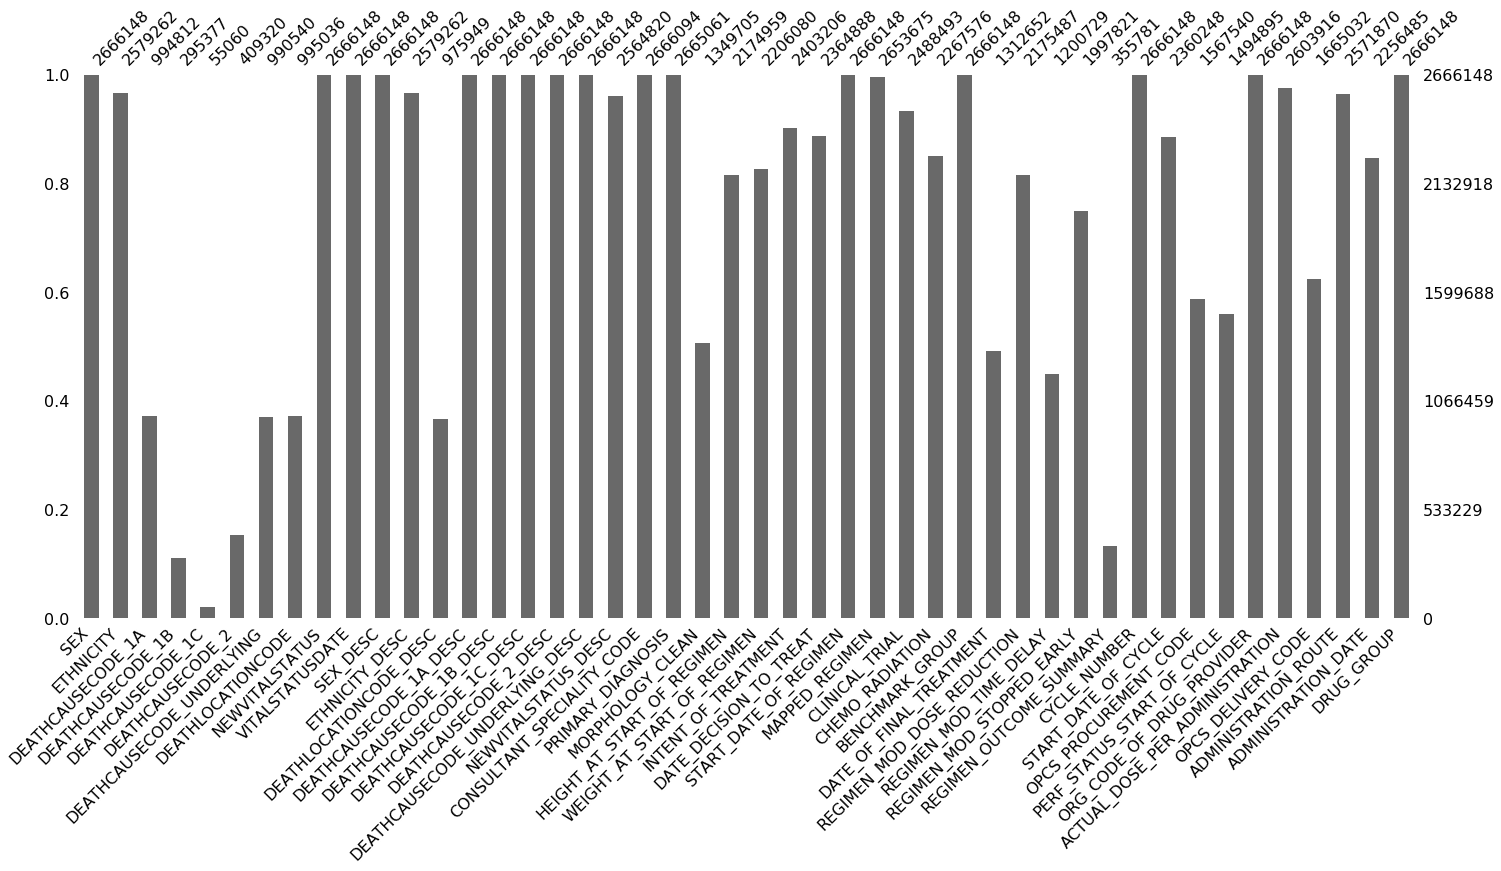

In [40]:
import missingno as msno

#plots the number of not NaN in each column
msno.bar(patient_pathways)

## Full Pathway (including av_tumour)

In [45]:
patient_pathways = pd.read_pickle('patient_pathways.pkl')

In [98]:
patient_pathways.shape

(2666148, 62)

In [100]:
z = sact_patient.rename(index=str,columns={'LINK_NUMBER':'LINKNUMBER'})

a = pd.merge(av_tumour, av_patient, on=['PATIENTID', 'SEX', 'LINKNUMBER'])
b = pd.merge(a, z, on='LINKNUMBER')
c = pd.merge(b, sact_tumour, on="MERGED_PATIENT_ID")
# clean the data by removing entries where 1st 3 chars of SITE_ICD10 a nd PRIMARY_DIAGNOSIS are not equal
c_cleaned = c[ c['SITE_ICD10_O2'].apply(lambda s: str(s)[0:3]) == c['PRIMARY_DIAGNOSIS'].apply(lambda s: str(s)[0:3]) ]
d = pd.merge(c_cleaned, sact_regimen, on='MERGED_TUMOUR_ID')
e = pd.merge(d, sact_outcome, on='MERGED_REGIMEN_ID')
f = pd.merge(e, sact_cycle, on='MERGED_REGIMEN_ID')
g = pd.merge(f, drug_detail, on='MERGED_CYCLE_ID')



In [101]:
g.shape

(1711512, 110)

In [102]:
g.head(20)

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,SITE_ICD10_O2_DESC,SITE_ICD10_O2_3CHAR_DESC,MORPH_ICD10_O2_DESC,BEHAVIOUR_ICD10_O2_DESC,STAGE_BEST_DESC,GRADE_DESC,SEX_DESC_x,CREG_CODE_DESC,ER_STATUS_DESC,PR_STATUS_DESC,HER2_STATUS_DESC,CANCERCAREPLANINTENT_DESC,PERFORMANCESTATUS_DESC,CNS_DESC,ACE27_DESC,LATERALITY_DESC,...,SEX_DESC_y,ETHNICITY_DESC,DEATHLOCATIONCODE_DESC,DEATHCAUSECODE_1A_DESC,DEATHCAUSECODE_1B_DESC,DEATHCAUSECODE_1C_DESC,DEATHCAUSECODE_2_DESC,DEATHCAUSECODE_UNDERLYING_DESC,NEWVITALSTATUS_DESC,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_x,CONSULTANT_SPECIALITY_CODE,PRIMARY_DIAGNOSIS,MORPHOLOGY_CLEAN,MERGED_REGIMEN_ID_x,HEIGHT_AT_START_OF_REGIMEN,WEIGHT_AT_START_OF_REGIMEN,INTENT_OF_TREATMENT,DATE_DECISION_TO_TREAT,START_DATE_OF_REGIMEN,MAPPED_REGIMEN,CLINICAL_TRIAL,CHEMO_RADIATION,MERGED_PATIENT_ID_y,BENCHMARK_GROUP,MERGED_OUTCOME_ID,DATE_OF_FINAL_TREATMENT,REGIMEN_MOD_DOSE_REDUCTION,REGIMEN_MOD_TIME_DELAY,REGIMEN_MOD_STOPPED_EARLY,REGIMEN_OUTCOME_SUMMARY,MERGED_PATIENT_ID_x,MERGED_TUMOUR_ID_y,MERGED_CYCLE_ID,CYCLE_NUMBER,START_DATE_OF_CYCLE,OPCS_PROCUREMENT_CODE,PERF_STATUS_START_OF_CYCLE,MERGED_PATIENT_ID_y,MERGED_TUMOUR_ID_x,MERGED_DRUG_DETAIL_ID,ORG_CODE_OF_DRUG_PROVIDER,ACTUAL_DOSE_PER_ADMINISTRATION,OPCS_DELIVERY_CODE,ADMINISTRATION_ROUTE,ADMINISTRATION_DATE,DRUG_GROUP,MERGED_PATIENT_ID,MERGED_TUMOUR_ID_y,MERGED_REGIMEN_ID_y
0,10000697,10000697,2013-12-05,C443,C44,8070,3,2,NaN,NaN,?,NaN,G2,69.0,2,L1701,810000697,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-05,R,3,Skin of other and unspecified parts of face,Other malignant neoplasms of skin,Squamous cell carcinoma,MALIGNANT,INSUFFICIENT INFO,2 / II / MODERATELY DIFFERENTIATED,FEMALE,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,Curative,NaN,NaN,NaN,RIGHT,...,FEMALE,S ANY OTHER ETHNIC GROUP,NaN,,,,,,Alive,10000697,10009764,800,C440,NaN,10009036,1.68,80.3,A,NaN,2014-03-29,Radium 223,02,N,10000697,POMALIDOMIDE,10004764,NaN,Y,Y,N,NaN,10000697,10009764,10009033,1,2014-03-29,X714,NaN,10000697,10009764,10007375,EDD31,700.0,X723,NaN,2014-04-01,FLUOROURACIL,10000697,10009764,10009036
1,10000697,10000697,2013-12-05,C443,C44,8070,3,2,NaN,NaN,?,NaN,G2,69.0,2,L1701,810000697,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-05,R,3,Skin of other and unspecified parts of face,Other malignant neoplasms of skin,Squamous cell carcinoma,MALIGNANT,INSUFFICIENT INFO,2 / II / MODERATELY DIFFERENTIATED,FEMALE,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,Curative,NaN,NaN,NaN,RIGHT,...,FEMALE,S ANY OTHER ETHNIC GROUP,NaN,,,,,,Alive,10000697,10009764,800,C440,NaN,10009036,1.68,80.3,A,NaN,2014-03-29,Radium 223,02,N,10000697,POMALIDOMIDE,10004764,NaN,Y,Y,N,NaN,10000697,10009764,10009033,1,2014-03-29,X714,NaN,10000697,10009764,10039138,ETG,500.0,X723,1.0,2014-08-10,ZOLEDRONIC ACID,10000697,10009764,10009036
2,10000697,10000697,2013-12-05,C443,C44,8070,3,2,NaN,NaN,?,NaN,G2,69.0,2,L1701,810000697,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-05,R,3,Skin of other and unspecified parts of face,Other malignant neoplasms of skin,Squamous cell carcinoma,MALIGNANT,INSUFFICIENT INFO,2 / II / MODERATELY DIFFERENTIATED,FEMALE,West Midlands Cancer Intelligence Unit,NaN,NaN,NaN,Curative,NaN,NaN,NaN,RIGHT,...,FEMALE,S ANY OTHER ETHNIC GROUP,NaN,,,,,,Alive,10000697,10009764,800,C440,NaN,10009036,1.68,80.3,A,NaN,2014-03-29,Radium 223,02,N,10000697,POMALIDOMIDE,10004764,NaN,Y,Y,N,NaN,10000697,10009764,10017216,7,2014-04-18,X702,NaN,10000697,10009764,10014450,EGT,930.0,NaN,1.0,2014-04-18,RITUXIMAB,10000697,10009764,10009036
3,10000697,10000697,2013-12-05,C443,C44,8070,3,2,NaN,NaN,?

In [124]:
%%time
full_patient_pathways = g \
                    .sort_values(by = 
                    ['PATIENTID', 'ADMINISTRATION_DATE', 'START_DATE_OF_CYCLE', 'START_DATE_OF_REGIMEN', 'DIAGNOSISDATEBEST']) 

CPU times: user 1.77 s, sys: 1.84 s, total: 3.61 s
Wall time: 4.67 s


In [116]:
full_patient_pathways[full_patient_pathways['PATIENTID'] == 10000697]['START_DATE_OF_REGIMEN']

0     2014-03-29
2     2014-03-29
3     2014-03-29
1     2014-03-29
4     2014-03-29
5     2014-03-29
6     2014-03-29
7     2014-03-29
8     2014-03-29
9     2014-03-29
10    2014-03-29
11    2014-03-29
12    2014-03-29
13    2014-03-29
14    2014-03-29
Name: START_DATE_OF_REGIMEN, dtype: object

In [117]:
full_patient_pathways['ADMINISTRATION_DATE'].isna().sum()

259620

In [120]:
full_patient_pathways['DIAGNOSISDATEBEST'].isna().sum()

0

In [125]:
full_patient_pathways[['PATIENTID', 'ADMINISTRATION_DATE', 'START_DATE_OF_CYCLE', 'START_DATE_OF_REGIMEN', 'DIAGNOSISDATEBEST']]

,PATIENTID,ADMINISTRATION_DATE,START_DATE_OF_CYCLE,START_DATE_OF_REGIMEN,DIAGNOSISDATEBEST
0,10000697,2014-04-01,2014-03-29,2014-03-29,2013-12-05
2,10000697,2014-04-18,2014-04-18,2014-03-29,2013-12-05
3,10000697,2014-04-18,2014-04-18,2014-03-29,2013-12-05
1,10000697,2014-08-10,2014-03-29,2014-03-29,2013-12-05
4,10000697,NaN,NaN,2014-03-29,2013-12-05
5,10000697,NaN,NaN,2014-03-29,2013-12-05
6,10000697,NaN,NaN,2014-03-29,2013-12-05
7,10000697,NaN,NaN,2014-03-29,2013-12-05
8,10000697,NaN,NaN,2014-03-29,2013-12-05
9,10000697,NaN,NaN,2014-03-29,2013-12-05
